# Birds Classification


## Google Colab Tutorial
---
https://colab.research.google.com/notebooks/

Settings used for: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. [PyTorch](http://pytorch.org).

In step 1 of the project I trained a deep convolutional network from scratch to recognize scenes. I designed a simple network architecture with jittering, normalization, and regularization.

For step 2 Fine-tuning a pre-trained deep network is involved. We used the pretrained AlexNet & ResNet network which was not trained to recognize scenes at all.

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

For Step 3 I trained a small Vision Transformer (ViT) from scratch. ViT is pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks(ImageNet, CIFAR-100, VTAB, etc.), ViT attains excellent results compared to state-of-the-art convolutional networks.


## Dataset
---
Under the root folder, there should be a folder named "data" containing the images.

## Some Tutorials (PyTorch)
---
- PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [1]:
# import packages here
import os
import sys
print (sys.executable)
import cv2
import numpy as np

import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch import Tensor
from typing import List, Optional
import torch.nn as nn
import torch.nn.functional as F

C:\Users\Jasper\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
# # Mount your google drive where you've saved your assignment folder
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# # Set your working directory (in your google drive)
# #   change it to your specific homework directory.
# %cd '/content/gdrive/MyDrive/CSE527_2'
%ls

 Volume in drive C has no label.
 Volume Serial Number is C0E0-2290

 Directory of C:\Users\Jasper\Downloads\CSE527_2

03/23/2024  01:02 AM    <DIR>          .
03/22/2024  02:46 PM    <DIR>          ..
03/22/2024  05:51 PM    <DIR>          .ipynb_checkpoints
03/23/2024  01:02 AM           765,728 CSE527_24S_hw2.ipynb
03/21/2024  07:19 PM    <DIR>          data
               1 File(s)        765,728 bytes
               4 Dir(s)  539,128,975,360 bytes free


## Loading and Preprocessing data
---
Loads data into minibatches for training and testing in PyTorch.

In [4]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')] # name attributes
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def img_rot(img):
  # Rotate the image by 90 degrees clockwise
  rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return rotated_img


# split data into train and test
def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, zoom=False, rotate=False, crop=False, is_color=False, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float64)/255*2-1)
    # Data Augmentation
    # print("data before augmentation: ", data)
    if augment:
        data.extend([img_rot(img) for img in data])
        labels.extend(labels)
        data.extend([img_rot(img_rot(img)) for img in data])
        labels.extend(labels)
        data.extend([np.fliplr(img) for img in data])
        labels.extend(labels)
        # print("data after augmentation: ", data)

    # Data Normalization
    if zero_centered:
        # for img in data:
        #     img -= np.mean(img)
        #     # img /= np.max(img) - np.min(img)
        data -= np.mean(data, 0)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels
    return zip(batch_data, batch_labels)

class_names: {0: '001.Black_footed_Albatross', 1: '002.Laysan_Albatross', 2: '005.Crested_Auklet', 3: '010.Red_winged_Blackbird', 4: '015.Lazuli_Bunting', 5: '016.Painted_Bunting', 6: '017.Cardinal', 7: '044.Frigatebird', 8: '047.American_Goldfinch', 9: '054.Blue_Grosbeak', 10: '070.Green_Violetear', 11: '074.Florida_Jay', 12: '087.Mallard', 13: '101.White_Pelican', 14: '159.Black_and_white_Warbler', 15: '187.American_Three_toed_Woodpecker', 16: '188.Pileated_Woodpecker', 17: '189.Red_bellied_Woodpecker', 18: '191.Red_headed_Woodpecker', 19: '192.Downy_Woodpecker'} 


In [5]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 34 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cla

054.Blue_Grosbeak
torch.Size([64, 64])


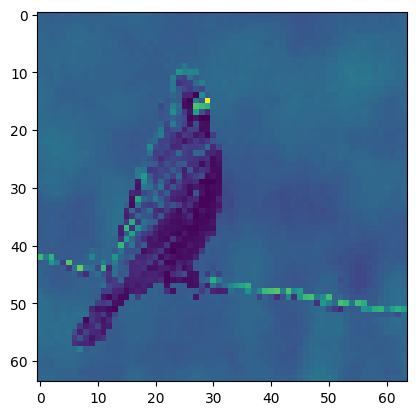

In [6]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    # plt.imshow(npimg, 'gray')
    plt.imshow(npimg)
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
print(img.shape)
imshow(img)

## Training a Network From Scratch [40 points]
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function.

A simpe network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()
      self.inners = torch.nn.Sequential(
        nn.Conv2d(1, 32, 5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(8192, 20), 
      )


    def forward(self, x):
      x = self.inners(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x 


Model training and evaluation functions.

In [8]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time

def trainModel(net, trainloader, train_option, testloader=None):
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1

  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()

  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))

    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [9]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time

def evalModel(net, testloader):
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()

  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)

  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))


Training and evaluation.

In [10]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())
net = TNet()
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 30
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Torch version: 2.2.1+cu121
Is CUDA enabled? True
Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0882 | Average Loss: 3.0882 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9925 | Average Loss: 3.5141 
Accuracy: 0.208333 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.0423 | Average Loss: 3.2714 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.3818 | Average Loss: 2.8944 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.4545 | Average Loss: 2.7348 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.9310 | Average Loss: 2.5032 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.1724 | Average Loss: 2.3767 
Epoch: 4 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.3963 | Average Loss: 2.1887 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.9051 | Average Loss: 2.0809 
Epoch: 5 | Iter:   20 | Time: 00:00:00 | Train Loss




### Boost the accuracy

**Data Augmentation**: We don't have enough training data, augment the training data is needed.
If you rotate an image of a scene, it almost never changes categories. A kitchen doesn't become a forest when rotated. We can synthetically increase our amount of training data by rotating training images during the learning process.


After we implement rotation, we notice that our training error doesn't drop as quickly. That means the network isn't overfitting to the original training images as much (because it sees more training images now, although they're not as good as truly independent samples). Because the training and test errors fall more slowly, we may need more training epochs.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference.

**Network Regularization**: Add a dropout layer. The training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. We insert a dropout layer between the convolutional layers. In particular, we inserted it directly before the last convolutional layer. The training accuracy should increase much more slowly. 

In [11]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 279 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cl

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()
      # self.inners = nn.Sequential(
      #       nn.Conv2d(1, 16, 3),
      #       nn.ReLU(),
      #       nn.MaxPool2d(2, stride=2),
      #       nn.Conv2d(16, 32, 3),
      #       nn.ReLU(),
      #       nn.MaxPool2d(4, stride=2),
      #       nn.Dropout(0.5),
      #       nn.Conv2d(32, 64, 3),
      #       nn.ReLU(),
      #       nn.MaxPool2d(2, stride=2),
      # )
          
      # self.classifier = nn.Sequential(
      #       nn.Linear(1600, 400),
      #       nn.ReLU(),
      #       nn.Linear(400, 20)
      # )
      self.inners = nn.Sequential(
            nn.Conv2d(1, 16, 3),         
            nn.ReLU(),         
            nn.MaxPool2d(2, stride=2),         
            nn.Conv2d(16, 32, 3),          
            nn.ReLU(),          
            nn.MaxPool2d(4, stride=2),      
            nn.Dropout(0.5),      
            nn.Conv2d(32, 16, 3),           
            nn.ReLU(),    
            nn.MaxPool2d(2, stride=2), 
      )
          
      self.classifier = nn.Sequential(
        nn.Linear(400, 20)
      )


    def forward(self, x):
      x = self.inners(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x 


In [13]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9543 | Average Loss: 2.9543 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9677 | Average Loss: 3.0037 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.8118 | Average Loss: 2.9787 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.9134 | Average Loss: 2.9691 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 3.0035 | Average Loss: 2.9580 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.7563 | Average Loss: 2.9295 
Epoch: 1 | Iter:  120 | Time: 00:00:00 | Train Loss: 2.5360 | Average Loss: 2.9167 
Epoch: 1 | Iter:  140 | Time: 00:00:00 | Train Loss: 2.3795 | Average Loss: 2.8877 
Epoch: 1 | Iter:  160 | Time: 00:00:00 | Train Loss: 2.7442 | Average Loss: 2.8558 
Epoch: 1 | Iter:  180 | Time: 00:00:00 | Train Loss: 2.4627 | Average Loss: 2.8307 
Epoch: 1 | Iter:  200 | Time: 00:00:00 | Train Loss: 2.5640 | Average Loss: 2.8096 
Epoch: 1 | Iter:  220 | Time: 00:00:00 | Train Loss: 2.7296 | Average Loss: 

Data augmentation: rotation

Data normalization: subtract the mean from every image

Layer 1: Convolution: nn.Conv2d(1, 16, 3)

Layer 2: ReLU:

Layer 3: maxPooling: nn.MaxPool2d(3, stride=2)

Layer 4: Convolution: nn.Conv2d(16, 16, 3)

Layer 5: ReLU:

Layer 6: maxPooling: nn.MaxPool2d(3, stride=2)

Layer 6: Dropout: nn.Dropout(0.5)

Layer 7: Convolution: nn.Conv2d(16, 8, 3)

Layer 8: ReLU:

Layer 9: maxPooling: nn.MaxPool2d(3, stride=2)

Layer 10: FC: nn.Linear(200, 22)


## Problem 1.2 [15 points]

 We tried **two techniques** to increase the accuracy of the model: e.g. increasing the training data by flipping the training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modifications.


### Technique 1

In [14]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()
      # self.inners = nn.Sequential(
      #       nn.Conv2d(1, 16, 3),
      #       nn.ReLU(),
      #       nn.BatchNorm2d(16),
      #       nn.MaxPool2d(2, stride=2),
      #       nn.Conv2d(16, 32, 3),
      #       nn.ReLU(),
      #       nn.BatchNorm2d(32),
      #       nn.MaxPool2d(4, stride=2),
      #       nn.Dropout(0.5),
      #       nn.Conv2d(32, 32, 3),
      #       nn.ReLU(),
      #       nn.BatchNorm2d(32),
      #       nn.MaxPool2d(2, stride=2),
      # )
      # self.classifier = nn.Sequential(
      #     nn.Linear(800, 200),
      #     nn.ReLU(),
      #     nn.Linear(200, 20)
      # )
      self.inners = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),  # Add Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),  # Add Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(16, 8, 3),
            # nn.BatchNorm2d(8),  # Add Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
      )
          
      self.classifier = nn.Sequential(
        nn.Linear(200, 20)
      )
          


    def forward(self, x):
      x = self.inners(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x 

In [15]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.00095
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.6574 | Average Loss: 3.6574 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 3.1188 | Average Loss: 3.0921 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.8189 | Average Loss: 3.0125 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.9680 | Average Loss: 2.9860 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 3.0589 | Average Loss: 2.9641 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.7288 | Average Loss: 2.9453 
Epoch: 1 | Iter:  120 | Time: 00:00:00 | Train Loss: 2.4892 | Average Loss: 2.9268 
Epoch: 1 | Iter:  140 | Time: 00:00:00 | Train Loss: 2.8430 | Average Loss: 2.9044 
Epoch: 1 | Iter:  160 | Time: 00:00:00 | Train Loss: 2.8089 | Average Loss: 2.8773 
Epoch: 1 | Iter:  180 | Time: 00:00:00 | Train Loss: 2.7430 | Average Loss: 2.8551 
Epoch: 1 | Iter:  200 | Time: 00:00:00 | Train Loss: 2.5249 | Average Loss: 2.8388 
Epoch: 1 | Iter:  220 | Time: 00:00:00 | Train Loss: 2.8541 | Average Loss: 


Method 1: add batch normalization



### Technique 2

In [16]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------

class TNet(nn.Module):
    def __init__(self):
          super(TNet, self).__init__()
          self.inners = nn.Sequential(
                nn.Conv2d(1, 16, 3),
                nn.Tanh(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(16, 32, 3),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(4, stride=2),
                nn.Dropout(0.5),
                nn.Conv2d(32, 64, 3),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2, stride=2),
          )
          
          self.classifier = nn.Sequential(
              nn.Linear(1600, 100),
              nn.ReLU(),
              nn.Linear(100, 20)
          )
          # self.inners = nn.Sequential(
          #   nn.Conv2d(1, 16, 3),
          #   nn.BatchNorm2d(16),  # Add Batch Normalization
          #   nn.Tanh(),
          #   nn.MaxPool2d(2, stride=2),
          #   nn.Conv2d(16, 16, 3),
          #   nn.BatchNorm2d(16),  # Add Batch Normalization
          #   nn.Tanh(),
          #   nn.MaxPool2d(2, stride=2),
          #   nn.Dropout(0.5),
          #   nn.Conv2d(16, 16, 3),
          #   nn.BatchNorm2d(16),  # Add Batch Normalization
          #   nn.Tanh(),
          #   nn.MaxPool2d(2, stride=2),
          # )
          
          # self.classifier = nn.Sequential(
          #   nn.Linear(576, 20)
          # )

    def forward(self, x):
        x = self.inners(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------

net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9222 | Average Loss: 2.9222 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.8443 | Average Loss: 3.1660 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.8189 | Average Loss: 2.9930 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.4450 | Average Loss: 2.8717 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 2.1218 | Average Loss: 2.8050 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.1117 | Average Loss: 2.7207 
Epoch: 1 | Iter:  120 | Time: 00:00:00 | Train Loss: 2.1392 | Average Loss: 2.6918 
Epoch: 1 | Iter:  140 | Time: 00:00:00 | Train Loss: 2.2186 | Average Loss: 2.6465 
Epoch: 1 | Iter:  160 | Time: 00:00:00 | Train Loss: 2.6859 | Average Loss: 2.6137 
Epoch: 1 | Iter:  180 | Time: 00:00:00 | Train Loss: 2.2196 | Average Loss: 2.5884 
Epoch: 1 | Iter:  200 | Time: 00:00:00 | Train Loss: 2.3806 | Average Loss: 2.5568 
Epoch: 1 | Iter:  220 | Time: 00:00:00 | Train Loss: 2.0908 | Average Loss: 


Method 2: replace activation layer into Tanh with larger learning rate


## Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks.

But how do we use an existing deep network for a new recognition task? For instance, the [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to the 1000 ImageNet categories.

- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- To fine-tune a pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### AlexNet

**Strategy A**: *Fine-tune* an existing network. In this scenario we take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for the recognition task. We are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When we don't have enough training data to train a complex network from scratch (e.g. with the 22 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from a pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

Below is an implementation for Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task.

In [21]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True,
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 34 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cla

In [22]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torch.optim as optim
import time
from torchvision import models

class alexTNet(nn.Module):
  def __init__(self):
      super(alexTNet, self).__init__()
      self.features = models.alexnet(weights='DEFAULT').features
      # Freeze convolutional layers
      for param in self.features.parameters():
        param.requires_grad = False
      self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),  # Modify input size to match AlexNet's output
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 20)  # Modify output size to match number of classes
        )  


  def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

net = alexTNet()
train_option = {}
train_option['epoch'] = 20
train_option['lr'] = 0.001
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr = train_option['lr'], momentum=0.9)
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1710 | Average Loss: 3.1710 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.9814 | Average Loss: 2.7591 
Accuracy: 0.520833 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.7317 | Average Loss: 2.4149 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 0.7037 | Average Loss: 1.8953 
Accuracy: 0.708333 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.1731 | Average Loss: 1.6482 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 0.2814 | Average Loss: 1.3695 
Accuracy: 0.729167 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0745 | Average Loss: 1.2270 
Epoch: 4 | Iter:   20 | Time: 00:00:00 | Train Loss: 0.1419 | Average Loss: 1.0653 
Accuracy: 0.750000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0577 | Average Loss: 0.9796 
Epoch: 5 | Iter:   20 | Time: 00:00:00 | Train Loss: 0.1297 | Average Loss: 0.8751 
Accuracy: 0.8125





The last two FC layers have been replaced.

The architecture of the new layers added including activation methods:

Data augmentation: left-right flip (mirror)

Data normalization: subtract the mean from every image

Features Layers : same as AlexNet

Classifier Layer 1: Dropout: same as AlexNet

Classifier Layer 2: FC: same as AlexNet

Classifier Layer 3: ReLU: same as AlexNet

Classifier Layer 4: Dropout: same as AlexNet

Classifier Layer 5: FC: nn.Linear(4096, 1024)

Classifier Layer 6: ReLU:

Classifier Layer 7: FC: nn.Linear(1024, 22)




### SVM
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. We trained a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer.

Below is an implementation for Strategy B where we use the activations of the pre-trained network as features to train one-vs-all SVMs for the scene classification task. 

In [23]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
import torch.optim as optim
import time
from torchvision import models
from sklearn import svm

class alexFeatTNet(nn.Module):
  def __init__(self):
    # super(alexFeatTNet, self).__init__()
    # self.alexnet = models.alexnet(weights = 'DEFAULT')
    # self.features = nn.Sequential(*list(self.alexnet.features.children()))
    # for w in self.features.parameters():
    #     w.requires_grad = False
    super(alexFeatTNet, self).__init__()
    self.alexnet = models.alexnet(weights='DEFAULT')
    self.features = nn.Sequential(*list(self.alexnet.features.children()))
    
    # Remove last linear layer
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
    self.classifier = nn.Sequential(*list(self.alexnet.classifier.children())[:-2])
    
    # Freeze the parameters of the feature extractor
    for w in self.features.parameters():
        w.requires_grad = False


  def forward(self, x):
    # features = self.features(x)
    # print(features.shape)
    features = self.features(x)
    features = self.avgpool(features)
    features = features.view(features.size(0), -1)
    features = self.classifier(features)
    return features[:, :1000]

def predFeat(net, testloader_large):
    features_list = []
    label_list = []
    
    # Set the model to evaluation mode
    net.eval()
    
    with torch.no_grad():
        for images, labels in testloader_large:
            images = images.float()  # Ensure images are on the same device as the network
            labels = labels.float().cpu().numpy()  # Convert labels to numpy on CPU
            
            # Compute features in batches to utilize GPU efficiently
            features = net(images).detach().cpu().numpy().reshape(len(images), -1)
            features_list.append(features)
            label_list.extend(labels)
    
    # Concatenate features and labels
    feat = np.vstack(features_list)
    label = np.array(label_list)
    # print(feat.shape)
    # print(label.shape)
    return feat, label


net = alexFeatTNet()
# print(net)
train_feat, train_label = predFeat(net, trainloader_large)
test_feat, test_label = predFeat(net, testloader_large)

In [24]:
# model training: take feature and label, return model
def train_SVM(X, Y):
    clf = svm.LinearSVC(random_state=0, tol=1e-4, C=22, loss='squared_hinge', max_iter=1000)
    clf.fit(X, Y)
    return clf

# prediction: take feature and model, return label
def predict_SVM(clf, X):
    predict = clf.predict(X)
    return predict

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

start_time = time.time()
train_feat_cut = list(map(lambda x:x[0:1000],train_feat))
clfs = train_SVM(train_feat_cut, train_label)

time_lapse = time.time() - start_time
print('Time: {}'.format(time_lapse))

start_time = time.time()
# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(len(test_feat)):
    predictions[i] = predict_SVM(clfs, np.reshape(test_feat[i][0:1000],(1,-1)))

predictions = np.reshape(np.array(predictions),(-1))

acc = np.sum(np.array(predictions) == np.array(test_label)) / float(len(test_label))
time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
print('Accuracy:{:5f} | Time: {}'.format(acc,time_lapse))



Time: 0.8870413303375244
Accuracy:0.812500 | Time: 00:00:00


### Resnet34
Fine tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) 

In [25]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torch.optim as optim
import time
from torchvision import models

class resTNet(nn.Module):
  def __init__(self):
      super(resTNet, self).__init__()
      self.resTNet = models.resnet34(weights = 'DEFAULT')
      self.features = nn.Sequential(*list(self.resTNet.children())[:-1])
      self.fc = nn.Linear(in_features=512, out_features=1000, bias=True)
      # print(self)
      # Freeze convolutional layers
      for param in self.features.parameters():
        param.requires_grad = False


  def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net = resTNet()
train_option={}
train_option['lr'] = 0.0015
train_option['epoch'] = 10
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr = train_option['lr'], momentum=0.9)
trainModel(net, trainloader_large, train_option, trainloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 6.8686 | Average Loss: 6.8686 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 3.3252 | Average Loss: 5.5078 
Accuracy: 0.488971 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.8236 | Average Loss: 4.4289 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.4850 | Average Loss: 3.5438 
Accuracy: 0.757353 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.9701 | Average Loss: 3.1415 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 0.9258 | Average Loss: 2.7270 
Accuracy: 0.895221 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:02 | Train Loss: 0.6365 | Average Loss: 2.5015 
Epoch: 4 | Iter:   20 | Time: 00:00:02 | Train Loss: 0.6450 | Average Loss: 2.2444 
Accuracy: 0.944853 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:02 | Train Loss: 0.4547 | Average Loss: 2.0958 
Epoch: 5 | Iter:   20 | Time: 00:00:03 | Train Loss: 0.4855 | Average Loss: 1.9181 
Accuracy: 0.9687

### Tramsformers
We built a Vision Transformer (ViT)! Transformers have achieved significant success in the field of Natural Language Processing, such as machine translation. ViT explores how to utilize transformers into computer vision tasks and attains excellent results compared to state-of-the-art convolutional networks.

Transformer paper: https://arxiv.org/pdf/1706.03762.pdf

Transformer tutorial: http://jalammar.github.io/illustrated-transformer/

ViT paper: https://openreview.net/pdf?id=YicbFdNTTy

ViT tutorial: https://www.youtube.com/watch?v=HZ4j_U3FC94




ViT consists of multiple transformer encoder layers (i.e. the left block of the following image). Our implementation includes a multi-head attention layer, a feed forward layer, two norm layers and two residual connections.


<img src="https://production-media.paperswithcode.com/method_collections/trans.jpeg" width="400">

In [26]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,
               embedding_dims = 128,
               dropout=0.1,
               mlp_hidden_dim = 32,
               num_heads = 2,
               ):
    super().__init__()

    self.self_attn = nn.MultiheadAttention(embedding_dims, num_heads, batch_first = True)
    self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dims, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, embedding_dims)
    )
    self.norm1 = nn.LayerNorm(embedding_dims)
    self.norm2 = nn.LayerNorm(embedding_dims)
    self.dropout = nn.Dropout(dropout)



  def forward(self,x): 
    [attn_output, _] = self.self_attn(x,x,x)
    x = self.norm1(x + self.dropout(attn_output))
    ff_output = self.feed_forward(x)
    x = self.norm2(x + self.dropout(ff_output))

    return x

<img src=https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png width="400">

ViT consists:


**1) Data Preprocessing**: Patchify process to transfer the image (batch_size, channel, height, width) to a sequence of tokens (batch_size, num_tokens, embedding_dimension).

**2) Positional Encoding**

**3) Extra Learnable [CLASS] embedding**

**4) Transformer Encoder**

**5) Prediction**: MLP Head and perform classification.

Test ViT on the MNIST dataset

In [27]:
class ViT(nn.Module):
  def __init__(self,
               img_size = 64,
               in_channels = 1,
               patch_size = 16,
               embedding_dims = 128,
               num_transformer_layers = 2,
               dropout = 0.1,
               mlp_hidden_dim = 128,
               num_heads = 2,
               num_classes = 22):
    super().__init__()
    '''
    img_size: img height and width.
    in_channels: 3 if RGB image, 1 if gray iamge
    patch_size: cut the image into patch_size * patch_size sub-regions
    embedding_dims: feature dimension of tokens
    num_transformer_layers: number of transformer encoder layer
    dropout: probability of dropout
    mlp_hidden_dim: hidden dim of MLP block
    num_heads: number of heads in multi-head attention
    num_classes: number of classes to predict

    You are suggested but not required to use all inputs.
    '''
    self.img_size = img_size
    self.patch_size = patch_size
    self.in_channels = in_channels
    
    # Determine the number of patches
    self.num_patches = (img_size // patch_size) ** 2
    
    # Patchify layer
    self.patchify = nn.Conv2d(in_channels, embedding_dims, kernel_size=patch_size, stride=patch_size)
    
    # Positional encoding
    self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dims))
    
    # Extra learnable [CLASS] embedding
    self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dims))
    
    # Transformer encoder layers
    self.transformer_encoder_layers = nn.ModuleList([
        TransformerEncoderLayer(embedding_dims, dropout, mlp_hidden_dim, num_heads)
        # nn.TransformerEncoderLayer(embedding_dims, num_heads, mlp_hidden_dim, dropout, batch_first = True)
        for _ in range(num_transformer_layers)
    ])
    
    # MLP head for classification
    self.mlp_head = nn.Sequential(
        nn.Linear(embedding_dims, mlp_hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden_dim, num_classes)
    )
    # print(self)

  def forward(self, x):
    bs, c, h, w = x.shape
    # print("before patchify:", x.shape)
    # Patchify the input image
    x = self.patchify(x)
    x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, embedding_dims)
    # print("after patchify:", x.shape)
    # Repeat self.cls_token along the batch dimension
    # print("cls_token shape:", self.cls_token.shape)
    
    # Concatenate cls_tokens and x along the batch dimension
    x = torch.cat((x,self.cls_token.repeat(bs, 1, 1)), dim = 1)
    
    # print("cls token embedding", x.shape)
    
    # Add positional encoding
    x = x + self.positional_encoding
    # print("after positional encoding:", x.shape)
    
    # Transformer encoder layers
    for layer in self.transformer_encoder_layers:
        x = layer(x)
    
    # Extract class token and pass through MLP head for classification
    cls_token = x[:, 0]
    # print(cls_token)
    x = self.mlp_head(cls_token)

    return x

In [28]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

transform = ToTensor()
train_set = MNIST(root='/content/sample_data', train=True, download=True, transform=transform)
test_set = MNIST(root='/content/sample_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [29]:
net = ViT(img_size = 28,
          in_channels = 1,
          patch_size = 7,
          embedding_dims = 128,
          num_transformer_layers = 3,
          dropout = 0.1,
          mlp_hidden_dim = 128,
          num_heads = 2,
          num_classes = 10)
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 5
train_option['device'] = 'gpu'
trainModel(net, train_loader, train_option, test_loader)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.3257 | Average Loss: 2.3257 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.0714 | Average Loss: 2.2610 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.1242 | Average Loss: 1.8970 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 0.5462 | Average Loss: 1.5308 
Epoch: 1 | Iter:   80 | Time: 00:00:01 | Train Loss: 0.5871 | Average Loss: 1.2971 
Epoch: 1 | Iter:  100 | Time: 00:00:01 | Train Loss: 0.4029 | Average Loss: 1.1287 
Epoch: 1 | Iter:  120 | Time: 00:00:01 | Train Loss: 0.3442 | Average Loss: 1.0102 
Epoch: 1 | Iter:  140 | Time: 00:00:01 | Train Loss: 0.2633 | Average Loss: 0.9147 
Epoch: 1 | Iter:  160 | Time: 00:00:02 | Train Loss: 0.2420 | Average Loss: 0.8416 
Epoch: 1 | Iter:  180 | Time: 00:00:02 | Train Loss: 0.2500 | Average Loss: 0.7804 
Epoch: 1 | Iter:  200 | Time: 00:00:02 | Train Loss: 0.3058 | Average Loss: 0.7284 
Epoch: 1 | Iter:  220 | Time: 00:00:02 | Train Loss: 0.3297 | Average Loss: 